# NB-AK6: Changes in Long-term snow and ice water equivanent for 21st early, mid and late period from historical period

## module loading...

In [1]:
%matplotlib inline  
import os
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)

mpl.rcParams['xtick.labelsize']='small'


The Python version: 3.7.0
xarray 0.16.2


In [2]:
from cmip5_oconus import print_date
print_date()

from cmip5_oconus.data_catalog import load_monthly_historical_hydro_datasets, resample_data
from cmip5_oconus.data_catalog import load_monthly_cmip5_hydro_datasets
from cmip5_oconus.plot import custom_div_cmap, MidpointNormalize, add_ylabel
from cmip5_oconus.utils import calc_change
from cmip5_oconus.data_catalog import DOMAIN

Last executed: 2021-03-06 10:09:27.506450 by mizukami on casper03


In [ ]:
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=9, threads=4, memory="108GB",
#                  walltime='00:40:00')
#cluster.scale(jobs=3)

#from dask_jobqueue import SLURMCluster
#cluster = SLURMCluster()
#cluster.scale(jobs=5)

In [ ]:
#from dask.distributed import Client
#client = Client(cluster)

In [ ]:
#client

-------------------------
## Setup 

In [3]:
gcms            = ["ACCESS1-3","CanESM2","CCSM4","CSIRO-Mk3-6-0","GFDL-ESM2M","HadGEM2-ES","inmcm4","MIROC5","MPI-ESM-MR","MRI-CGCM3"]
hydro_flux_vars = ['SWE', 'IWE']
period_hist     = slice('1970-01-01', '1999-12-31')
period_futr     = {'early' : slice('2010-01-01', '2039-12-31'),
                   'middle': slice('2040-01-01', '2069-12-31'),
                   'late'  : slice('2070-01-01', '2099-12-31')}

## Load the data

In [4]:
ds1 = xr.open_dataset(DOMAIN['AK'])
mask = ds1['mask'].where(ds1['mask']==1).notnull()

In [5]:
xr.set_options(file_cache_maxsize=12000)
histo_data = load_monthly_historical_hydro_datasets(models=gcms, variables=hydro_flux_vars, region='AK', parallel=False)
rcp45_data = load_monthly_cmip5_hydro_datasets(scen='rcp45', models=gcms, variables=hydro_flux_vars, region='AK', parallel=False)
rcp85_data = load_monthly_cmip5_hydro_datasets(scen='rcp85', models=gcms, variables=hydro_flux_vars, region='AK', parallel=False)

load_monthly_historical_hydro_datasets
load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

load_obs_dataset


load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [00:51<00:00,  5.13s/it]

load_monthly_cmip5_hydro_datasets
load_cmip5_dataset



100%|██████████| 10/10 [00:49<00:00,  4.96s/it]


In [6]:
# Select only winter months - 1 through 6
histo_data_winter = {}
for key, val in histo_data.items():
    histo_data_winter[key] = histo_data[key].where(histo_data[key].time.dt.month.isin([1,2,3,4,5,6]), drop=True)
rcp45_data_winter = rcp45_data.where(rcp45_data.time.dt.month.isin([1,2,3,4,5,6]), drop=True)
rcp85_data_winter = rcp85_data.where(rcp85_data.time.dt.month.isin([1,2,3,4,5,6]), drop=True)

## Compute 30 year annual mean for 4 periods - historical, early, mid and late

In [7]:
histo_hydro_means = resample_data(histo_data_winter['gcm'].sel(time=period_hist), region='AK', freq='AS', chunks=365).persist().mean('time')

rcp45_hydro_means = {}
rcp85_hydro_means = {}
for key, futr_period in period_futr.items():
    rcp45_hydro_means[key] = resample_data(rcp45_data_winter.sel(time=futr_period), region='AK', freq='AS', chunks=365).persist().mean('time')
    rcp85_hydro_means[key] = resample_data(rcp85_data_winter.sel(time=futr_period), region='AK', freq='AS', chunks=365).persist().mean('time')

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

In [8]:
# non-glacier pixels are zero, computing change in percent cause those pixes are filled with nan and plots get strange. so fill non zero (0.001) at non-glacier pixels.  
histo_hydro_means['IWE'] = histo_hydro_means['IWE'].where((histo_hydro_means['IWE']>0) | (np.isnan(histo_hydro_means['IWE'])), 0.001)

for key, futr_period in period_futr.items():
    rcp45_hydro_means[key]['IWE'] = rcp45_hydro_means[key]['IWE'].where((rcp45_hydro_means[key]['IWE']>0) | (np.isnan(rcp45_hydro_means[key]['IWE'])), 0.001)
    rcp85_hydro_means[key]['IWE'] = rcp85_hydro_means[key]['IWE'].where((rcp85_hydro_means[key]['IWE']>0) | (np.isnan(rcp85_hydro_means[key]['IWE'])), 0.001)

## Compute difference in 30 year annual mean between historical and future

In [9]:
rcp45_hydro_30yr_diff = {}
rcp85_hydro_30yr_diff = {}
diff_rcp_hydro_30yr_change ={}
for key, futr_period in period_futr.items():
    rcp45_hydro_30yr_diff[key] = calc_change(histo_hydro_means, rcp45_hydro_means[key], pct=True).persist()
    rcp85_hydro_30yr_diff[key] = calc_change(histo_hydro_means, rcp85_hydro_means[key], pct=True).persist()
    
    diff_rcp_hydro_30yr_change[key] =rcp85_hydro_30yr_diff[key] - rcp45_hydro_30yr_diff[key]

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

In [ ]:
# mask pecent change is less than -99%  
#for key, futr_period in period_futr.items():
#    rcp45_hydro_30yr_diff[key] = rcp45_hydro_30yr_diff[key].where(rcp45_hydro_30yr_diff[key]>-99)
#    rcp85_hydro_30yr_diff[key] = rcp85_hydro_30yr_diff[key].where(rcp85_hydro_30yr_diff[key]>-99)

## Plotting

In [10]:
# create colormap for SWE and IWE
# ---------------

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.Spectral_r(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(0.9, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

In [11]:
# create colormap for SWE and IWE change
# ---------------

# create a colormap that consists of
# 25 descrete colormap from red to blue

cmap_tmp = custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue')
newcolors = cmap_tmp(np.linspace(0, 1, 25))
grey = np.array([256/256, 256/256, 256/256, 1])
newcolors[:1, :] = grey
cmap_delta = mpl.colors.ListedColormap(newcolors)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

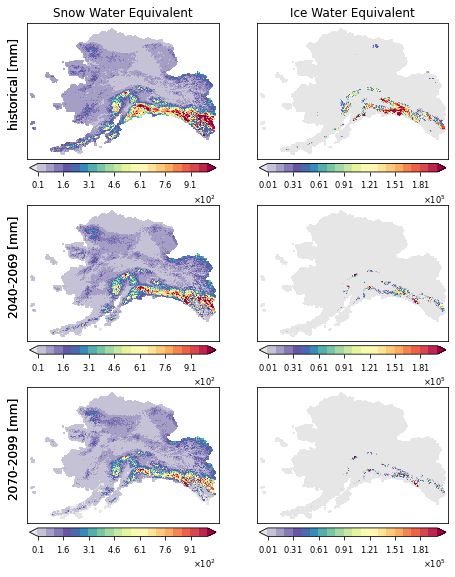

In [18]:
cm = {'mean': cmap}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 
                'cbar_kwargs': {'orientation':"horizontal", 'shrink':0.975, 'pad':0.03, 'format':sfmt}}
kwargs = {'SWE': {'levels':21, 'vmin':10,   'vmax':1010,   'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'IWE': {'levels':21, 'vmin':1000, 'vmax':201000, 'cmap':cm['mean'], 'extend':'both', **style_kwargs}
          }

var_title = {'SWE':'Snow Water Equivalent', 'IWE':'Ice Water Equivalent'}

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(6.5,7.75))
plt.subplots_adjust(left=0.075, bottom=0.020, right=0.975, top=0.970, hspace=0.100)

for col, var in enumerate(['SWE','IWE']):
    histo_hydro_means.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    rcp85_hydro_means['middle'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[1, col], **kwargs[var])
    rcp85_hydro_means['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[2, col], **kwargs[var])
    
    add_ylabel(axes[0, 0], 'historical [mm]', fontsize=12)
    add_ylabel(axes[1, 0], '2040-2069 [mm]', fontsize=12)
    add_ylabel(axes[2, 0], '2070-2099 [mm]', fontsize=12)
    axes[0, col].set_title(var_title[var], fontsize=12)

plt.savefig(f'NB-AK6_Fig1_winter_mean_snow_ice_hist_mid_late_rcp85.png', dpi=300)

------------
 - Change in 30yr mean annual total between historical and late 21st century

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

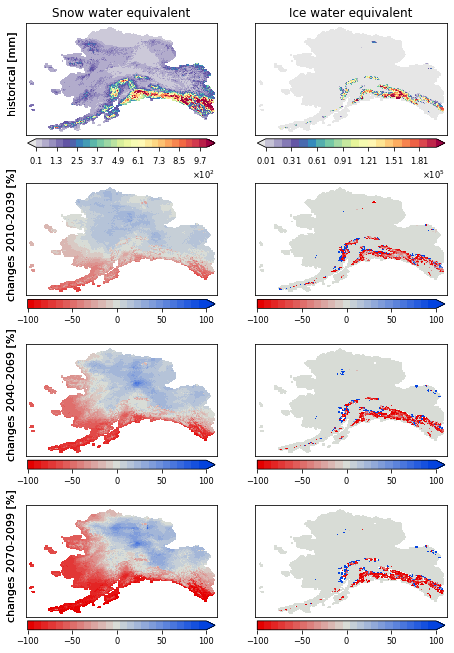

In [13]:
cm = {'history': cmap,
      'change' : custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'history':{"orientation":"horizontal", "shrink":0.980, "pad":0.03, 'format':sfmt},
              'change': {"orientation":"horizontal", "shrink":0.980, "pad":0.03}}

style_kwargs = {'history':{'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['history']},
                'change': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['change']}
               }

kwargs = {'change':  {'vmin':-100, 'vmax':100,    'cmap':cm['change'],  'extend':'max', **style_kwargs['change']},
          'SWE':     {'levels':26, 'vmin':10,   'vmax':1010,   'cmap':cm['history'], 'extend':'both', **style_kwargs['history']},
          'IWE':     {'levels':21, 'vmin':1000, 'vmax':201000, 'cmap':cm['history'], 'extend':'both', **style_kwargs['history']}
         }

var_title = {'SWE':'Snow water equivalent', 'IWE':'Ice water equivalent'}

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True, figsize=(6.5,9))
plt.subplots_adjust(left=0.075, bottom=0.020, right=0.975, top=0.975, hspace=0.175)

for col, var in enumerate(['SWE','IWE']):
    histo_hydro_means.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    
    early  = rcp85_hydro_30yr_diff['early'].mean(dim='gcm')[var].where(rcp85_hydro_30yr_diff['early'].mean(dim='gcm')[var]>-99)
    middle = rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var].where(rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var]>-99)
    late   = rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].where(rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var]>-99)
    early.plot.pcolormesh(ax=axes[1, col], **kwargs['change'])
    middle.plot.pcolormesh(ax=axes[2, col], **kwargs['change'])
    late.plot.pcolormesh(ax=axes[3, col],   **kwargs['change'])
    
    add_ylabel(axes[0, 0], 'historical [mm]', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2010-2039 [%]', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2040-2069 [%]', fontsize=11)
    add_ylabel(axes[3, 0], 'changes 2070-2099 [%]', fontsize=11)
    axes[0, col].set_title(var_title[var], fontsize=12)
    
#plt.tight_layout()
plt.savefig(f'NB-AK6_Fig2_winter_mean_snow_ice_pchange_rcp85.png', dpi=300)

------------
-  The same as above except for two future periods in 21st century (mid, and late)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

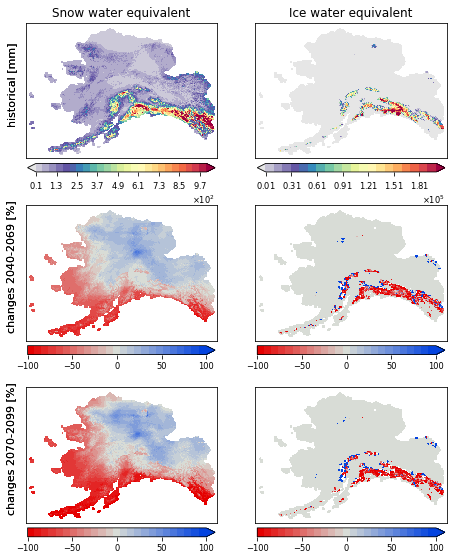

In [17]:
cm = {'history': cmap,
      'change' : custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'history':{"orientation":"horizontal", "shrink":0.980, "pad":0.03, 'format':sfmt},
              'change': {"orientation":"horizontal", "shrink":0.980, "pad":0.03}}

style_kwargs = {'history':{'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['history']},
                'change': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['change']}
               }

kwargs = {'change':  {'vmin':-100, 'vmax':100,    'cmap':cm['change'],  'extend':'max', **style_kwargs['change']},
          'SWE':     {'levels':26, 'vmin':10,   'vmax':1010,   'cmap':cm['history'], 'extend':'both', **style_kwargs['history']},
          'IWE':     {'levels':21, 'vmin':1000, 'vmax':201000, 'cmap':cm['history'], 'extend':'both', **style_kwargs['history']}
         }

var_title = {'SWE':'Snow water equivalent', 'IWE':'Ice water equivalent'}

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(6.5,7.75))
plt.subplots_adjust(left=0.075, bottom=0.020, right=0.975, top=0.970, hspace=0.100)

for col, var in enumerate(['SWE','IWE']):
    histo_hydro_means.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
        
    middle = rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var].where(rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var]>-99)
    late   = rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].where(rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var]>-99)
    middle.plot.pcolormesh(ax=axes[1, col], **kwargs['change'])
    late.plot.pcolormesh(ax=axes[2, col],   **kwargs['change'])
    
    add_ylabel(axes[0, 0], 'historical [mm]', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2040-2069 [%]', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2070-2099 [%]', fontsize=11)
    axes[0, col].set_title(var_title[var], fontsize=12)
    
#plt.tight_layout()
plt.savefig(f'NB-AK6_Fig3_winter_mean_snow_ice_pchange_mid_late_rcp85.png', dpi=300)

In [ ]:
2226.63-2165

In [ ]:
350*27